## 中毒患者预测模型
- M1 预测急诊转入院患者是否死亡
- M2 预测急诊转入院患者是否未治愈

## 寻找最优随机种子

In [ ]:
#预测值
# -*- coding: utf-8 -*-
import copy
import re

import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn import metrics
from sklearn.model_selection import train_test_split
from matplotlib.font_manager import FontProperties
#import shap
import pickle
import joblib
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
# import xgboost
import os
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import precision_recall_fscore_support
from sklearn.neural_network import MLPClassifier
import catboost
from catboost import *
import warnings
warnings.filterwarnings("ignore")
import random
from tqdm import tqdm

"""##  寻找最优随机种子
## 连续变量缺失值处理函数定义
def data_fillna(X, x_categorical, x_continuous):
    '''
    数据缺失值处理函数
    参数:X: pandas DataFrame对象
        x_categorical: 分类变量列表
        x_continuous: 连续变量列表
    返回:X: 处理后的pandas DataFrame对象
    '''
    for col in x_categorical:
        X[col] = (X[col].fillna(0)).astype('int64')
    for col in x_continuous:
        # mean_val = X[column].mean()
        mean_val = X[col].median()
        X[col].fillna(mean_val,inplace=True)
    return X
## 数据集准备函数定义,
def prepare_data(raw_data_path, x_continuous, x_categorical, y_column, isnan_flag=True, type_flag=None):
    '''
    准备数据集，包括数据预处理和特征工程
    参数: raw_data_path: 原始数据文件路径
        x_continuous: 连续变量列表
        x_categorical: 分类变量列表
        y_column: 目标变量列名
        isnan_flag: 是否缺失值，默认为True
    返回:datax: 特征数据
        datay: 目标变量
    '''
    rawdata = pd.read_excel(raw_data_path)
    rawdata = rawdata.sample(frac=1, random_state=42)
    if type_flag:
        rawdata = rawdata[rawdata['Type of Poisoning'] == type_flag]
    else:
        pass
    if  isnan_flag:
        for col in x_categorical:
            rawdata[col] = (rawdata[col].fillna(0)).astype('int64')
    else:
        rawdata =data_fillna(rawdata, x_categorical, x_continuous)
    datax = rawdata[x_continuous + x_categorical]
    datay = rawdata[y_column]
    return datax, datay

def model_10cv_Catboost(X,y,save_path,seed):
    skf = StratifiedKFold(n_splits=5)
    model = CatBoostClassifier(iterations=500, learning_rate=0.01, random_seed=seed)  ## 最优种子 seed=616
    t = y.values
    allAUC = []
    allY = []
    allPY = []
    fold = 0
    for train_index, test_index in skf.split(np.zeros(len(t)),t):
        X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        model.fit(X_train,y_train)
        probs = model.predict_proba(X_test)
        y_tepred = probs[:,1]
        auc_te = metrics.roc_auc_score(y_test, y_tepred)
        print('auc_te = ', auc_te, file=log)
        allAUC.append(auc_te)
        allY.extend(y_test)
        allPY.extend(y_tepred)
        ## 保存模型文件
        fold += 1
        if not os.path.exists(save_path +'models/'):
            os.makedirs(save_path +'models/')
        joblib.dump(model, save_path +'models/'+ f'Catboost_model_fold_{fold}.pkl')        
    
    meanAUC = np.mean(allAUC)
    print('====Catboost model: meanAUC={}'.format(meanAUC))
    print('====Catboost model: 95% CI=[{}, {}]'.format(np.percentile(allAUC,2.5), np.percentile(allAUC,97.5)))
    print('====Catboost model: meanAUC={}'.format(meanAUC), file=log)
    print('====Catboost model: 95% CI=[{}, {}]'.format(np.percentile(allAUC, 2.5), np.percentile(allAUC, 97.5)),
          file=log)
    print('====Catboost model: AUCS={}'.format(allAUC), file=log)
    predict_result = pd.DataFrame({'y_test':allY,'y_tepred':allPY})
    if os.path.exists(save_path + '/Catboost/')==False:
        os.makedirs(save_path + '/Catboost/')
    predict_result.to_csv(save_path + f'/Catboost/predict_result_Catboost.csv',index=False)
    return model,predict_result

font = FontProperties(fname='/usr/share/fonts/truetype/wqy/wqy-zenhei.ttc')
pwd = '/share/home/zhanxueyun/poisoning_file/raw_data/'
raw_data_path = pwd + 'rawdata_中毒数据_patient_last_1114.xlsx'

save_path = '/share/home/zhanxueyun/poisoning_file/raw_res/M1_compare/'
if not os.path.exists(save_path):
    os.makedirs(save_path)
if not os.path.exists(save_path + '/models_compare_results.txt'):
    with open(save_path + '/models_compare_results.txt', "w") as file:
        pass
log = open(save_path + '/models_compare_results.txt', mode="a+", encoding="utf-8")


# 生成 10 个不重复的随机种子
seeds = random.sample(range(1, 1000), 10)
print(seeds)
seeds = [725, 181, 206, 693, 616, 679, 102, 355, 770, 174]

def model_10cv_Catboost(X,y,save_path,seed):
    skf = StratifiedKFold(n_splits=5)
    model = CatBoostClassifier(iterations=500, learning_rate=0.01, random_seed=seed)
    t = y.values
    allAUC = []
    allY = []
    allPY = []
    fold = 0
    for train_index, test_index in skf.split(np.zeros(len(t)),t):
        X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        model.fit(X_train,y_train)
        probs = model.predict_proba(X_test)
        y_tepred = probs[:,1]
        auc_te = metrics.roc_auc_score(y_test, y_tepred)
        print('auc_te = ', auc_te)
        allAUC.append(auc_te)
        allY.extend(y_test)
        allPY.extend(y_tepred)    
    
    meanAUC = np.mean(allAUC)
    print('====Catboost model: meanAUC={}'.format(meanAUC))
    print('====Catboost model: 95% CI=[{}, {}]'.format(np.percentile(allAUC,2.5), np.percentile(allAUC,97.5)))
    print('====Catboost model: meanAUC={}'.format(meanAUC))
    print('====Catboost model: 95% CI=[{}, {}]'.format(np.percentile(allAUC,2.5), np.percentile(allAUC,97.5)))
    predict_result = pd.DataFrame({'y_test':allY,'y_tepred':allPY})
    if os.path.exists(save_path + '/Catboost/')==False:
        os.makedirs(save_path + '/Catboost/')
    # predict_result.to_csv(save_path + f'/Catboost/predict_result_Catboost.csv',index=False)
    return model,predict_result,meanAUC

save_path = '/share/home/zhanxueyun/poisoning_file/raw_res/'
raw_data_path = pwd + 'rawdata_中毒数据_patient_last_1114.xlsx'

'''  
## 全部特征
x_features_continuous_raw = ['Age','Length of Stay','Weight','Systolic Blood Pressure','Diastolic Blood Pressure','Respiratory Rate','White Blood Cell Count','Red Blood Cell Count','Hemoglobin Concentration','Mean Corpuscular Volume','Mean Corpuscular Hemoglobin','Mean Corpuscular Hemoglobin Concentration','Platelet Count','Mean Platelet Volume','Alanine Aminotransferase (ALT)','Total Bilirubin','Direct Bilirubin','Lactate Dehydrogenase (LDH)','Urea','Serum Creatinine','Uric Acid','Creatine Kinase (CK)','Creatine Kinase-MB Isoenzyme','Troponin I','High-Sensitivity C-Reactive Protein (hs-CRP)','Homocysteine','Potassium','Sodium','Chloride','Carbon Dioxide','Prothrombin Time','D-Dimer','Lactate','Blood Cholinesterase Test Results','Albumin','Number of Hemoperfusion Sessions','Number of Blood Purification Sessions','Hyperbaric Oxygen Therapy Duration and Frequency','Atropine Dosage','Long-acting Nitroglycerin Dosage','Pralidoxime Dosage']  # ��续变量列表
x_features_categorical_raw = ['Gender','Education Level','Residential address','Type of Poisoning','Hypertension','Hyperlipidemia','Diabetes Mellitus','Cerebrovascular Disease','Heart Disease','Allergy History','Cancer','Poisoning','Degree of poisoning','Smoking Status','Alcohol Consumption Status','Shortness of Breath','Chest Pain','Cough','Pre-syncope','Altered Consciousness or Syncope','Sore Throat','Fever','Fatigue','Lower Limb Edema','Palpitations','Vomiting','Nausea','Weakness','Headache'] # 分类变量列表
## 全部特征
x_features_continuous_re = ['Age','Length of Stay','Weight','Systolic Blood Pressure','Diastolic Blood Pressure','Respiratory Rate','WBC','RBC','Hgb','MCV','MCH','MCHC','Platelet Count','Mean Platelet Volume','ALT','Total Bilirubin','Direct Bilirubin','LDH','Urea','Serum Creatinine','Uric Acid','Creatine Kinase (CK)','CK-MB','Troponin I','hs-CRP','Homocysteine','Potassium','Sodium','Chloride','Carbon Dioxide','Prothrombin Time','D-Dimer','Lactate','ChE','Alt-first','Number of Hemoperfusion Sessions','Number of Blood Purification Sessions','Hyperbaric Oxygen Therapy Duration and Frequency','Atropine Dosage','Long-acting Nitroglycerin Dosage','Pralidoxime Dosage']  # ��续变量列表
x_features_categorical_re = ['Gender','Education Level','Residential address','Type of Poisoning','Hypertension','Hyperlipidemia','Diabetes Mellitus','Cerebrovascular Disease','Heart Disease','Allergy History','Cancer','Poisoning','Degree of poisoning','Smoking Status','Alcohol Consumption Status','Shortness of Breath','Chest Pain','Cough','Pre-syncope','AMS or Sync','Sore Throat','Fever','Fatigue','Lower Limb Edema','Palpitations','Vomiting','Nausea','Weakness','Headache'] # 分类变量列表

# 是否死亡的特征
## 全部患者，20个特征，原始特征名
x_features_categorical_raw = ['Type of Poisoning','Degree of poisoning','Altered Consciousness or Syncope','Education Level']
x_features_continuous_raw = ['White Blood Cell Count','Alanine Aminotransferase (ALT)','Length of Stay','Total Bilirubin','Creatine Kinase-MB Isoenzyme','Age','Urea','Lactate Dehydrogenase (LDH)','Uric Acid','Albumin (First Measurement)','Albumin (Last Measurement)','Homocysteine','Hemoglobin Concentration','Direct Bilirubin','Creatine Kinase (CK)','Red Blood Cell Count','Mean Corpuscular Hemoglobin Concentration']
## 全部患者，20个特征，新的特征名
x_features_categorical_re = ['Type of Poisoning','Degree of poisoning','AMS or Sync','Education Level']
x_features_continuous_re = ['WBC','ALT','Length of Stay','Total Bilirubin','CK-MB','Age','Urea','LDH','Uric Acid','Alt-first','Alt-last','Homocysteine','Hgb','Direct Bilirubin','Creatine Kinase (CK)','RBC','MCHC']

# 是否恢复的特征
## 全部患者，20个特征，原始特征名
x_features_categorical_raw = ['Type of Poisoning','Degree of poisoning','Vomiting']
x_features_continuous_raw = ['Age','Length of Stay','Weight','Diastolic Blood Pressure','White Blood Cell Count','Mean Corpuscular Volume','Alanine Aminotransferase (ALT)','Total Bilirubin','Lactate Dehydrogenase (LDH)','Urea','Uric Acid','Creatine Kinase (CK)','Creatine Kinase-MB Isoenzyme','High-Sensitivity C-Reactive Protein (hs-CRP)','Blood Cholinesterase Test Results','Albumin (First Measurement)','Albumin (Last Measurement)']
## 全部患者，20个特征，新的特征名
x_features_categorical_re = ['Type of Poisoning','Degree of poisoning','Vomiting']
x_features_continuous_re = ['Age','Length of Stay','Weight','Diastolic Blood Pressure','WBC','MCV','ALT','Total Bilirubin','LDH','Urea','Uric Acid','Creatine Kinase','CK-MB','hs-CRP','ChE','Alb-first','Alb-last']

## # 是否死亡的特征,全部患者，33个特征，原始特征名
x_features_categorical_raw = ['Type of Poisoning','Degree of poisoning','Altered Consciousness or Syncope','Education Level','Vomiting','Nausea']
x_features_continuous_raw = ['White Blood Cell Count','Alanine Aminotransferase (ALT)','Length of Stay','Total Bilirubin','Creatine Kinase-MB Isoenzyme','Age','Urea','Lactate Dehydrogenase (LDH)','Uric Acid','Albumin (First Measurement)','Homocysteine','Hemoglobin Concentration','Direct Bilirubin','Creatine Kinase (CK)','Red Blood Cell Count','Mean Corpuscular Hemoglobin Concentration',
                             'High-Sensitivity C-Reactive Protein (hs-CRP)','Serum Creatinine','Troponin I','Mean Corpuscular Volume','Mean Corpuscular Hemoglobin','D-Dimer','Platelet Count','Potassium','Sodium','Chloride','Carbon Dioxide','Prothrombin Time','Lactate']
## 全部患者，33个特征，新的特征名
x_features_categorical_re = ['Type of Poisoning','Degree of poisoning','AMS or Sync','Education Level','Vomiting','Nausea']
x_features_continuous_re = ['WBC','ALT','Length of Stay','Total Bilirubin','CK-MB','Age','Urea','LDH','Uric Acid','Alt-first','Homocysteine','Hgb','Direct Bilirubin','Creatine Kinase (CK)','RBC','MCHC',
                            'hs-CRP','Serum Creatinine','Troponin I','MCV','MCH','D-Dimer','Platelet Count','Potassium','Sodium','Chloride','Carbon Dioxide','Prothrombin Time','Lactate']
'''
# 是否恢复的特征,31个特征
## 全部患者，31个特征，原始特征名
x_features_categorical_raw = ['Type of Poisoning','Degree of poisoning','Vomiting','Nausea']
x_features_continuous_raw = ['Age','Length of Stay','Weight','Diastolic Blood Pressure','White Blood Cell Count','Mean Corpuscular Volume','Alanine Aminotransferase (ALT)','Total Bilirubin','Lactate Dehydrogenase (LDH)','Urea','Uric Acid','Creatine Kinase (CK)','Creatine Kinase-MB Isoenzyme','High-Sensitivity C-Reactive Protein (hs-CRP)','Blood Cholinesterase Test Results','Albumin (First Measurement)','Albumin (Last Measurement)',
                                'Serum Creatinine','Troponin I','Mean Corpuscular Hemoglobin','D-Dimer','Platelet Count','Potassium','Sodium','Chloride','Carbon Dioxide','Prothrombin Time','Lactate']
## 全部患者，31个特征，新的特征名
x_features_categorical_re = ['Type of Poisoning','Degree of poisoning','Vomiting','Nausea']
x_features_continuous_re = ['Age','Length of Stay','Weight','Diastolic Blood Pressure','WBC','MCV','ALT','Total Bilirubin','LDH','Urea','Uric Acid','Creatine Kinase','CK-MB','hs-CRP','ChE','Alb-first','Alb-last',
                            'Serum Creatinine','Troponin I','MCH','D-Dimer','Platelet Count','Potassium','Sodium','Chloride','Carbon Dioxide','Prothrombin Time','Lactate']



datax_miss, datay = prepare_data(raw_data_path , x_features_continuous_raw, x_features_categorical_raw, 'Outcome', False)  # 数据处理   'Outcome_other' 是否死亡; 'Outcome'  是否未治愈
datax_miss.columns = x_features_continuous_re + x_features_categorical_re
datax_miss[x_features_categorical_re] = datax_miss[x_features_categorical_re].astype('int64')
# --------------------------
# 主循环（带进度条）
# --------------------------
results = []
for seed in tqdm(seeds, desc="Processing seeds"):
    model, predict_result, meanAUC = model_10cv_Catboost(datax_miss, datay, save_path, seed)
    results.append({"Seed": seed, "AUROC": meanAUC})
# 输出结果
results_df = pd.DataFrame(results)
# results_df.to_csv(save_path + 'seed_auc_1.csv')
print(results_df)
print(f"平均AUROC: {results_df['AUROC'].mean():.4f}")
"""

## M1 模型

In [10]:
#预测值
# -*- coding: utf-8 -*-
import copy
import re

import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn import metrics
from sklearn.model_selection import train_test_split
from matplotlib.font_manager import FontProperties
#import shap
import pickle
import joblib
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
# import xgboost
import os
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import precision_recall_fscore_support
from sklearn.neural_network import MLPClassifier
import catboost
from catboost import *
import warnings
warnings.filterwarnings("ignore")

# font = FontProperties(fname='/usr/share/fonts/truetype/wqy/wqy-zenhei.ttc')

raw_data_path = 'rawdata_中毒数据_patient_last_1114.xlsx'

save_path = 'M1_compare/'

if not os.path.exists(save_path):
    os.makedirs(save_path)
if not os.path.exists(save_path + '/models_compare_results.txt'):
    with open(save_path + '/models_compare_results.txt', "w") as file:
        pass
log = open(save_path + '/models_compare_results.txt', mode="a+", encoding="utf-8")

## 连续变量缺失值处理函数定义
def data_fillna(X, x_categorical, x_continuous):
    """
    数据缺失值处理函数
    参数:X: pandas DataFrame对象
        x_categorical: 分类变量列表
        x_continuous: 连续变量列表
    返回:X: 处理后的pandas DataFrame对象
    """
    for col in x_categorical:
        X[col] = (X[col].fillna(0)).astype('int64')
    for col in x_continuous:
        # mean_val = X[column].mean()
        mean_val = X[col].median()
        X[col].fillna(mean_val,inplace=True)
    return X
## 数据集准备函数定义,
def prepare_data(raw_data_path, x_continuous, x_categorical, y_column, isnan_flag=True, type_flag=None):
    """
    准备数据集，包括数据预处理和特征工程
    参数: raw_data_path: 原始数据文件路径
        x_continuous: 连续变量列表
        x_categorical: 分类变量列表
        y_column: 目标变量列名
        isnan_flag: 是否缺失值，默认为True
    返回:datax: 特征数据
        datay: 目标变量
    """
    rawdata = pd.read_excel(raw_data_path)
    rawdata = rawdata.sample(frac=1, random_state=42)
    if type_flag:
        rawdata = rawdata[rawdata['Type of Poisoning'] == type_flag]
    else:
        pass
    if  isnan_flag:
        for col in x_categorical:
            rawdata[col] = (rawdata[col].fillna(0)).astype('int64')
    else:
        rawdata =data_fillna(rawdata, x_categorical, x_continuous)
    datax = rawdata[x_continuous + x_categorical]
    datay = rawdata[y_column]
    return datax, datay

def model_10cv_Catboost(X,y,save_path,seed):
    skf = StratifiedKFold(n_splits=5)
    model = CatBoostClassifier(iterations=500, learning_rate=0.01, random_seed=seed)  ## 最优种子 seed=616
    t = y.values
    allAUC = []
    allY = []
    allPY = []
    fold = 0
    for train_index, test_index in skf.split(np.zeros(len(t)),t):
        X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        model.fit(X_train,y_train)
        probs = model.predict_proba(X_test)
        y_tepred = probs[:,1]
        auc_te = metrics.roc_auc_score(y_test, y_tepred)
        print('auc_te = ', auc_te, file=log)
        allAUC.append(auc_te)
        allY.extend(y_test)
        allPY.extend(y_tepred)
        ## 保存模型文件
        fold += 1
        if not os.path.exists(save_path +'models/'):
            os.makedirs(save_path +'models/')
        joblib.dump(model, save_path +'models/'+ f'Catboost_model_fold_{fold}.pkl')        
    
    meanAUC = np.mean(allAUC)
    print('====Catboost model: meanAUC={}'.format(meanAUC))
    print('====Catboost model: 95% CI=[{}, {}]'.format(np.percentile(allAUC,2.5), np.percentile(allAUC,97.5)))
    print('====Catboost model: meanAUC={}'.format(meanAUC), file=log)
    print('====Catboost model: 95% CI=[{}, {}]'.format(np.percentile(allAUC, 2.5), np.percentile(allAUC, 97.5)),
          file=log)
    print('====Catboost model: AUCS={}'.format(allAUC), file=log)
    predict_result = pd.DataFrame({'y_test':allY,'y_tepred':allPY})
    if os.path.exists(save_path + '/Catboost/')==False:
        os.makedirs(save_path + '/Catboost/')
    predict_result.to_csv(save_path + f'/Catboost/predict_result_Catboost.csv',index=False)
    return model,predict_result

############################################### 当前数据源配置 ##############################################
'''## 全部患者，20个特征，原始特征名
x_features_categorical_raw = ['Type of Poisoning','Degree of poisoning','Altered Consciousness or Syncope','Education Level','Vomiting','Nausea']
x_features_continuous_raw = ['White Blood Cell Count','Alanine Aminotransferase (ALT)','Length of Stay','Total Bilirubin','Creatine Kinase-MB Isoenzyme','Age','Urea','Lactate Dehydrogenase (LDH)','Uric Acid','Albumin (First Measurement)','Homocysteine','Hemoglobin Concentration','Direct Bilirubin','Creatine Kinase (CK)','Red Blood Cell Count','Mean Corpuscular Hemoglobin Concentration',
                             'High-Sensitivity C-Reactive Protein (hs-CRP)','Serum Creatinine','Troponin I','Mean Corpuscular Volume','Mean Corpuscular Hemoglobin','D-Dimer','Platelet Count','Potassium','Sodium','Chloride','Carbon Dioxide','Prothrombin Time','Lactate']
## 全部患者，20个特征，新的特征名
x_features_categorical_re = ['Type of Poisoning','Degree of poisoning','AMS or Sync','Education Level','Vomiting','Nausea']
x_features_continuous_re = ['WBC','ALT','Length of Stay','Total Bilirubin','CK-MB','Age','Urea','LDH','Uric Acid','Alt-first','Homocysteine','Hgb','Direct Bilirubin','Creatine Kinase (CK)','RBC','MCHC',
                            'hs-CRP','Serum Creatinine','Troponin I','MCV','MCH','D-Dimer','Platelet Count','Potassium','Sodium','Chloride','Carbon Dioxide','Prothrombin Time','Lactate']
'''
## # 是否死亡的特征,全部患者，33个特征，原始特征名
x_features_categorical_raw = ['Type of Poisoning','Degree of poisoning','Altered Consciousness or Syncope','Education Level','Vomiting','Nausea']
x_features_continuous_raw = ['White Blood Cell Count','Alanine Aminotransferase (ALT)','Length of Stay','Total Bilirubin','Creatine Kinase-MB Isoenzyme','Age','Urea','Lactate Dehydrogenase (LDH)','Uric Acid','Albumin (First Measurement)','Homocysteine','Hemoglobin Concentration','Direct Bilirubin','Creatine Kinase (CK)','Red Blood Cell Count','Mean Corpuscular Hemoglobin Concentration',
                             'High-Sensitivity C-Reactive Protein (hs-CRP)','Serum Creatinine','Troponin I','Mean Corpuscular Volume','Mean Corpuscular Hemoglobin','D-Dimer','Platelet Count','Potassium','Sodium','Chloride','Carbon Dioxide','Prothrombin Time','Lactate']

# 数据处理
datax_miss, datay = prepare_data(raw_data_path , x_features_continuous_raw, x_features_categorical_raw, 'Outcome_other', False)  # 缺失值填充

# 保证分类列为整数类型
datax_miss[x_features_categorical_raw] = datax_miss[x_features_categorical_raw].astype('int64')

seed = 355  # 最优随机种子
model_Catboost,predict_result_Catboost = model_10cv_Catboost(datax_miss,datay,save_path,seed)  # 缺失值填充



0:	learn: 0.6807045	total: 2.28ms	remaining: 1.14s
1:	learn: 0.6701566	total: 4.14ms	remaining: 1.03s
2:	learn: 0.6579069	total: 5.94ms	remaining: 984ms
3:	learn: 0.6454133	total: 7.52ms	remaining: 933ms
4:	learn: 0.6349686	total: 9.84ms	remaining: 974ms
5:	learn: 0.6249209	total: 11.8ms	remaining: 975ms
6:	learn: 0.6152245	total: 14.2ms	remaining: 1s
7:	learn: 0.6057086	total: 16.2ms	remaining: 996ms
8:	learn: 0.5950326	total: 18ms	remaining: 984ms
9:	learn: 0.5835512	total: 20ms	remaining: 980ms
10:	learn: 0.5733817	total: 21.9ms	remaining: 973ms
11:	learn: 0.5649850	total: 24.5ms	remaining: 995ms
12:	learn: 0.5546163	total: 26.4ms	remaining: 988ms
13:	learn: 0.5467995	total: 28.4ms	remaining: 985ms
14:	learn: 0.5383686	total: 30.8ms	remaining: 995ms
15:	learn: 0.5304788	total: 32ms	remaining: 967ms
16:	learn: 0.5231687	total: 33.9ms	remaining: 964ms
17:	learn: 0.5161959	total: 35.8ms	remaining: 960ms
18:	learn: 0.5085737	total: 37.8ms	remaining: 957ms
19:	learn: 0.5010501	total: 39.

In [11]:
import os
import numpy as np
import pandas as pd
import shap
import warnings
warnings.filterwarnings("ignore")
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap


def analyze_model_dataset_m1(model, X, save_path):
    """
    为M1模型生成SHAP值和图，并保存相关文件（修正版，支持CatBoost）
    """
    output_dir = os.path.join(save_path, 'SHAP')
    os.makedirs(output_dir, exist_ok=True)

    # 1️⃣ 计算SHAP值
    explainer = shap.Explainer(model)
    shap_values = explainer(X)

    # ✅ CatBoost 二分类可能返回 [class0, class1]
    if isinstance(shap_values, list):
        shap_values = shap_values[1]

    # 2️⃣ 保存 SHAP 值矩阵
    shap_df = pd.DataFrame(shap_values.values, columns=X.columns)
    shap_df.to_csv(os.path.join(output_dir, 'shap_values.csv'), index=False)

    # 3️⃣ 保存原始输入数据（对应每个样本）
    shap_data_df = pd.DataFrame(shap_values.data, columns=X.columns)
    shap_data_df.to_csv(os.path.join(output_dir, 'shap_data.csv'), index=False)

    # 4️⃣ 计算并保存特征重要性
    feature_importance = pd.DataFrame({
        'Feature': X.columns,
        'Importance': np.abs(shap_values.values).mean(axis=0)  # ✅ 修正这里
    }).sort_values('Importance', ascending=False)
    feature_importance.to_csv(os.path.join(output_dir, 'feature_importance.csv'), index=False)

    # 5️⃣ 绘制 Summary Plot
    cmap = get_cmap('cool')
    plt.figure(figsize=(6, 8))
    shap.summary_plot(shap_values, X, cmap=cmap, show=False)
    plt.title("(M1) SHAP Feature Importance", fontsize=15)
    plt.xlabel("SHAP Value (Impact on model output)", fontsize=12)
    plt.tight_layout(pad=2.0)
    plt.savefig(os.path.join(output_dir, 'shap_summary_plot.png'), dpi=300, bbox_inches='tight')
    plt.close()

    print("✅ SHAP 文件已保存至:", output_dir)
    return explainer, shap_values, shap_df, feature_importance


# ======================================
# 使用示例
# ======================================
save_path = 'M1_compare/'  # M1模型路径
explainer_m1, shap_values_m1, shap_df_m1, feature_importance_m1 = analyze_model_dataset_m1(
    model_Catboost, datax_miss, save_path
)


✅ SHAP 文件已保存至: M1_compare/SHAP


## M2

In [12]:
#预测值
# -*- coding: utf-8 -*-
import copy
import re

import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn import metrics
from sklearn.model_selection import train_test_split
#import shap
import pickle
import joblib
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from matplotlib.font_manager import FontProperties
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
# import xgboost
import os
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import precision_recall_fscore_support
from sklearn.neural_network import MLPClassifier
import catboost
from catboost import *
import warnings
warnings.filterwarnings("ignore")

raw_data_path = 'rawdata_中毒数据_patient_last_1114.xlsx'

save_path = 'M2_compare/'

if not os.path.exists(save_path):
    os.makedirs(save_path)
if not os.path.exists(save_path + '/models_compare_results.txt'):
    with open(save_path + '/models_compare_results.txt', "w") as file:
        pass
log = open(save_path + '/models_compare_results.txt', mode="a+", encoding="utf-8")

## 连续变量缺失值处理函数定义
def data_fillna(X, x_categorical, x_continuous):
    """
    数据缺失值处理函数
    参数:X: pandas DataFrame对象
        x_categorical: 分类变量列表
        x_continuous: 连续变量列表
    返回:X: 处理后的pandas DataFrame对象
    """
    for col in x_categorical:
        X[col] = (X[col].fillna(0)).astype('int64')
    for col in x_continuous:
        # mean_val = X[column].mean()
        mean_val = X[col].median()
        X[col].fillna(mean_val,inplace=True)
    return X
## 数据集准备函数定义,
def prepare_data(raw_data_path, x_continuous, x_categorical, y_column, isnan_flag=True, type_flag=None):
    """
    准备数据集，包括数据预处理和特征工程
    参数: raw_data_path: 原始数据文件路径
        x_continuous: 连续变量列表
        x_categorical: 分类变量列表
        y_column: 目标变量列名
        isnan_flag: 是否缺失值，默认为True
    返回:datax: 特征数据
        datay: 目标变量
    """
    rawdata = pd.read_excel(raw_data_path)
    rawdata = rawdata.sample(frac=1, random_state=42)
    if type_flag:
        rawdata = rawdata[rawdata['Type of Poisoning'] == type_flag]
    else:
        pass
    if  isnan_flag:
        for col in x_categorical:
            rawdata[col] = (rawdata[col].fillna(0)).astype('int64')
    else:
        rawdata =data_fillna(rawdata, x_categorical, x_continuous)
    datax = rawdata[x_continuous + x_categorical]
    datay = rawdata[y_column]
    return datax, datay

def model_10cv_Catboost(X,y,save_path,seed):
    skf = StratifiedKFold(n_splits=5)
    model = CatBoostClassifier(iterations=500, learning_rate=0.01, random_seed=seed)
    t = y.values
    allAUC = []
    allY = []
    allPY = []
    fold = 0
    for train_index, test_index in skf.split(np.zeros(len(t)),t):
        X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        model.fit(X_train,y_train)
        probs = model.predict_proba(X_test)
        y_tepred = probs[:,1]
        auc_te = metrics.roc_auc_score(y_test, y_tepred)
        print('auc_te = ', auc_te, file=log)
        allAUC.append(auc_te)
        allY.extend(y_test)
        allPY.extend(y_tepred)
        ## 保存模型文件
        fold += 1
        if not os.path.exists(save_path +'models/'):
            os.makedirs(save_path +'models/')
        joblib.dump(model, save_path +'models/'+ f'Catboost_model_fold_{fold}.pkl')        
    
    meanAUC = np.mean(allAUC)
    print('====Catboost model: meanAUC={}'.format(meanAUC))
    print('====Catboost model: 95% CI=[{}, {}]'.format(np.percentile(allAUC,2.5), np.percentile(allAUC,97.5)))
    print('====Catboost model: meanAUC={}'.format(meanAUC), file=log)
    print('====Catboost model: 95% CI=[{}, {}]'.format(np.percentile(allAUC, 2.5), np.percentile(allAUC, 97.5)),
          file=log)
    print('====Catboost model: AUCS={}'.format(allAUC), file=log)
    predict_result = pd.DataFrame({'y_test':allY,'y_tepred':allPY})
    if os.path.exists(save_path + '/Catboost/')==False:
        os.makedirs(save_path + '/Catboost/')
    predict_result.to_csv(save_path + f'/Catboost/predict_result_Catboost.csv',index=False)
    return model,predict_result

############################################### 当前数据源配置 ##############################################
''' ## 全部患者，20个特征，原始特征名
x_features_categorical_raw = ['Type of Poisoning','Degree of poisoning','Vomiting']
x_features_continuous_raw = ['Age','Length of Stay','Weight','Diastolic Blood Pressure','White Blood Cell Count','Mean Corpuscular Volume','Alanine Aminotransferase (ALT)','Total Bilirubin','Lactate Dehydrogenase (LDH)','Urea','Uric Acid','Creatine Kinase (CK)','Creatine Kinase-MB Isoenzyme','High-Sensitivity C-Reactive Protein (hs-CRP)','Blood Cholinesterase Test Results','Albumin (First Measurement)','Albumin (Last Measurement)']
## 全部患者，20个特征，新的特征名
x_features_categorical_re = ['Type of Poisoning','Degree of poisoning','Vomiting']
x_features_continuous_re = ['Age','Length of Stay','Weight','Diastolic Blood Pressure','WBC','MCV','ALT','Total Bilirubin','LDH','Urea','Uric Acid','Creatine Kinase','CK-MB','hs-CRP','ChE','Alb-first','Alb-last']
'''
# 是否恢复的特征,31个特征
## 全部患者，31个特征，原始特征名
x_features_categorical_raw = ['Type of Poisoning','Degree of poisoning','Vomiting','Nausea']
x_features_continuous_raw = ['Age','Length of Stay','Weight','Diastolic Blood Pressure','White Blood Cell Count','Mean Corpuscular Volume','Alanine Aminotransferase (ALT)','Total Bilirubin','Lactate Dehydrogenase (LDH)','Urea','Uric Acid','Creatine Kinase (CK)','Creatine Kinase-MB Isoenzyme','High-Sensitivity C-Reactive Protein (hs-CRP)','Blood Cholinesterase Test Results','Albumin (First Measurement)','Albumin (Last Measurement)',
                                'Serum Creatinine','Troponin I','Mean Corpuscular Hemoglobin','D-Dimer','Platelet Count','Potassium','Sodium','Chloride','Carbon Dioxide','Prothrombin Time','Lactate']

datax_miss, datay = prepare_data(raw_data_path , x_features_continuous_raw, x_features_categorical_raw, 'Outcome', False)  # 缺失值填充

datax_miss[x_features_categorical_raw] = datax_miss[x_features_categorical_raw].astype('int64')

seed = 102 # 最优随机种子
model_Catboost,predict_result_Catboost = model_10cv_Catboost(datax_miss,datay,save_path,seed)  # 缺失值填充



0:	learn: 0.6869825	total: 2.5ms	remaining: 1.25s
1:	learn: 0.6811487	total: 5.2ms	remaining: 1.29s
2:	learn: 0.6757852	total: 7.11ms	remaining: 1.18s
3:	learn: 0.6711780	total: 8.64ms	remaining: 1.07s
4:	learn: 0.6671696	total: 10.1ms	remaining: 999ms
5:	learn: 0.6624610	total: 11.6ms	remaining: 952ms
6:	learn: 0.6587762	total: 13.1ms	remaining: 922ms
7:	learn: 0.6528432	total: 15.4ms	remaining: 948ms
8:	learn: 0.6473476	total: 17.3ms	remaining: 941ms
9:	learn: 0.6433967	total: 19.2ms	remaining: 940ms
10:	learn: 0.6387014	total: 21.6ms	remaining: 962ms
11:	learn: 0.6342379	total: 23.2ms	remaining: 942ms
12:	learn: 0.6298478	total: 24.6ms	remaining: 922ms
13:	learn: 0.6260732	total: 26.1ms	remaining: 906ms
14:	learn: 0.6219869	total: 27.6ms	remaining: 891ms
15:	learn: 0.6177032	total: 29.5ms	remaining: 893ms
16:	learn: 0.6139943	total: 32ms	remaining: 908ms
17:	learn: 0.6099529	total: 33.8ms	remaining: 905ms
18:	learn: 0.6056931	total: 35.4ms	remaining: 896ms
19:	learn: 0.6016909	total

In [13]:
import os
import numpy as np
import pandas as pd
import shap
import warnings
warnings.filterwarnings("ignore")
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap


def analyze_model_dataset_m1(model, X, save_path):
    """
    为M1模型生成SHAP值和图，并保存相关文件（修正版，支持CatBoost）
    """
    output_dir = os.path.join(save_path, 'SHAP')
    os.makedirs(output_dir, exist_ok=True)

    # 1️⃣ 计算SHAP值
    explainer = shap.Explainer(model)
    shap_values = explainer(X)

    # ✅ CatBoost 二分类可能返回 [class0, class1]
    if isinstance(shap_values, list):
        shap_values = shap_values[1]

    # 2️⃣ 保存 SHAP 值矩阵
    shap_df = pd.DataFrame(shap_values.values, columns=X.columns)
    shap_df.to_csv(os.path.join(output_dir, 'shap_values.csv'), index=False)

    # 3️⃣ 保存原始输入数据（对应每个样本）
    shap_data_df = pd.DataFrame(shap_values.data, columns=X.columns)
    shap_data_df.to_csv(os.path.join(output_dir, 'shap_data.csv'), index=False)

    # 4️⃣ 计算并保存特征重要性
    feature_importance = pd.DataFrame({
        'Feature': X.columns,
        'Importance': np.abs(shap_values.values).mean(axis=0)  # ✅ 修正这里
    }).sort_values('Importance', ascending=False)
    feature_importance.to_csv(os.path.join(output_dir, 'feature_importance.csv'), index=False)

    # 5️⃣ 绘制 Summary Plot
    cmap = get_cmap('cool')
    plt.figure(figsize=(6, 8))
    shap.summary_plot(shap_values, X, cmap=cmap, show=False)
    plt.title("(M2) SHAP Feature Importance", fontsize=15)
    plt.xlabel("SHAP Value (Impact on model output)", fontsize=12)
    plt.tight_layout(pad=2.0)
    plt.savefig(os.path.join(output_dir, 'shap_summary_plot.png'), dpi=300, bbox_inches='tight')
    plt.close()

    print("✅ SHAP 文件已保存至:", output_dir)
    return explainer, shap_values, shap_df, feature_importance


# ======================================
# 使用示例
# ======================================
save_path = 'M2_compare/'  # M1模型路径
explainer_m1, shap_values_m1, shap_df_m1, feature_importance_m1 = analyze_model_dataset_m1(
    model_Catboost, datax_miss, save_path
)


✅ SHAP 文件已保存至: M2_compare/SHAP


## SHAP分析

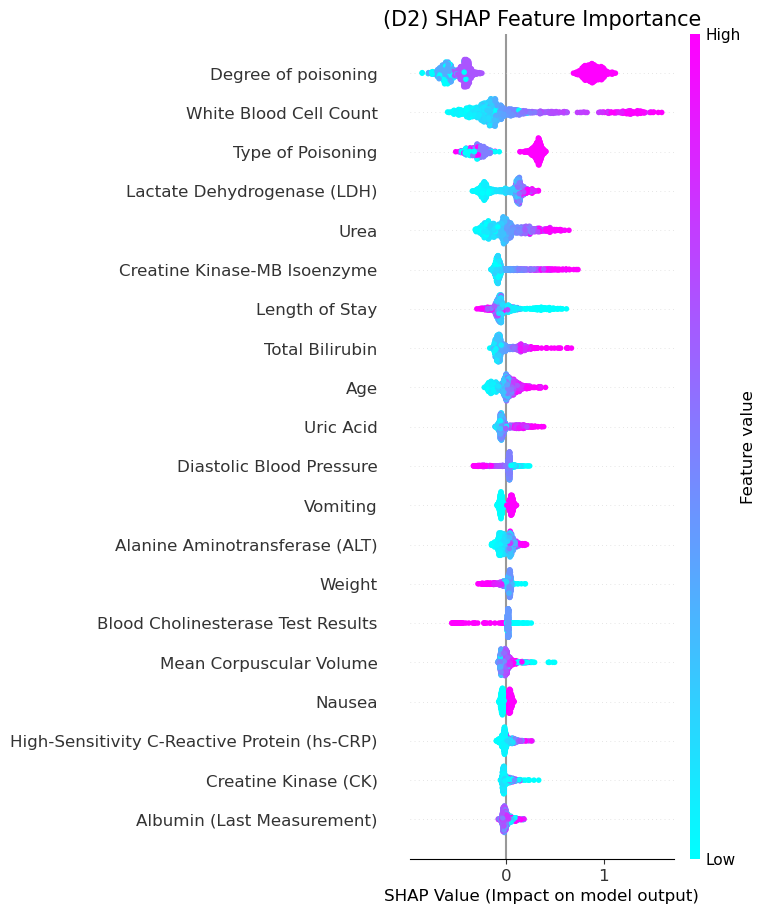

In [ ]:
# 导入包
import copy
import sys
import re
import os
import numpy as np
import pandas as pd
import shap
from shap.plots import waterfall
from tqdm import tqdm
from sklearn import metrics
from sklearn.model_selection import train_test_split
import pickle
from sklearn.model_selection import StratifiedKFold
import catboost
from catboost import *
import warnings
warnings.filterwarnings("ignore")
import matplotlib
matplotlib.use('Agg')
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
from sklearn.inspection import permutation_importance
import lightgbm as lgb
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import math
from sklearn import metrics, utils
from joblib import Parallel, delayed
from matplotlib.cm import get_cmap
import matplotlib.style as mplstyle
from datetime import datetime
from sklearn.utils import resample
from sklearn.metrics import (
    precision_recall_curve,
    brier_score_loss,
    auc,
    classification_report,
    confusion_matrix,
	average_precision_score,
	precision_recall_fscore_support,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve
)
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import itertools
import json
import yaml
import scipy as stats
import scipy.stats as st
from scipy.stats import ttest_ind,norm
import scipy.special
import scipy
import seaborn as sns
from matplotlib.colors import Normalize
from tabulate import tabulate
from sklearn.neighbors import KernelDensity
import plotly.express as px



def analyze_model_dataset(model, X, save_path):
    output_dir = f'{save_path}/SHAP/'
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    # Calculate SHAP values
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X)
    # Save SHAP values
    model_name = model.__module__.split('.')[0]
    shap_df = pd.DataFrame(shap_values, columns=X.columns)
    shap_df.to_csv(f'{output_dir}/shap_values.csv', index=False)
    expected_value = explainer.expected_value   #[1]
    # np.save(f'{output_dir}/{model_name}_expected_value.npy', expected_value)
    # Calculate and save feature importance
    feature_importance = pd.DataFrame({
        'Feature': X.columns,
        'Importance': np.abs(shap_values).mean(0)
    }).sort_values('Importance', ascending=False)
    feature_importance.to_csv(f'{output_dir}/feature_importance.csv', index=False)
    return explainer, shap_values, shap_df, expected_value, feature_importance


## shap_datax_miss.csv, catboost_shap_values.csv, catboost_feature_importance.csv
## 调用函数绘制
%matplotlib inline  
save_path = 'M2_compare/'  #   M2_compare/
model_name = model_Catboost.__module__.split('.')[0]
explainer, shap_values, shap_df, expected_value, feature_importance = analyze_model_dataset(model_Catboost, datax_miss, save_path)
pd.concat([shap_df,datax_miss],axis=1).to_csv(f'{save_path}/SHAP/shap_data.csv',index=False)


# SHAP Feature Importance
output_dir = f'{save_path}/SHAP/'
cmap = get_cmap('cool')  # 'plasma'、'rainbow'  'viridis' cool   ocean   
plt.figure(figsize=(6, 8))
shap.summary_plot(shap_values, datax_miss, cmap=cmap, show=False)
plt.title(f"(D2) SHAP Feature Importance", fontsize=15)
plt.xlabel("SHAP Value (Impact on model output)", fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout(pad=2.0)
plt.gca().tick_params(axis='y')  # 将y轴标签顺时针旋转30度
plt.savefig(f'{output_dir}/{model_name}_shap_summary_plot.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

